In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 


In [2]:
w = h = 28
input_dim=784

In [3]:
import pandas as pd
data = pd.read_csv("emnist-balanced-train.csv")
data_t = pd.read_csv('emnist-balanced-test.csv')
data_t.head()
a=list(data)[0]
b= list(data_t)[0]
indexNames = data_t[data_t[b] > 35].index
data_t.drop(indexNames, inplace=True)
indexNames0 = data_t[data_t[b] <10].index
data_t.drop(indexNames0, inplace=True)

indexNames = data[data[a] > 35].index
data.drop(indexNames, inplace=True)
indexNames0 = data[data[a] <10].index
data.drop(indexNames0, inplace=True)
data_t.shape, data.shape

train_data = data.iloc[:, 1:]
train_labels = data.iloc[:, 0]
test_data = data_t.iloc[:, 1:]
test_labels = data_t.iloc[:, 0]

train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
train_labels.head()

,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,35
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


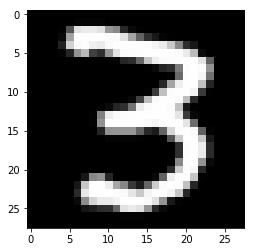

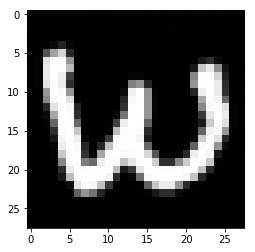

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [4]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.4
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values
del data, data_t
import matplotlib.pyplot as plt

plt.imshow(test_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()

import numpy as np
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    image = noisy('gauss',image)
    return (image.reshape([28 * 28]))/255.0
train_data = np.apply_along_axis(rotate, 1, train_data)
test_data = np.apply_along_axis(rotate, 1, test_data)
plt.imshow(test_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()
plt.figure()

In [5]:
batch_size = 64
x_batches, y_batches = train_data[batch_size: (2) * batch_size], train_labels[batch_size: (2) * batch_size]
x_batches.shape

(64, 784)

In [6]:
NUM = train_data.shape[0]
loss1 = []

def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for i in range(NUM // batch_size):
            # Get a batch
            #batch = mnist.train.next_batch(batch_size)
            x_batches, y_batches = train_data[i * batch_size: (i + 1) * batch_size], train_labels[i * batch_size: (i + 1) * batch_size]
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(x_batches)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            loss1.append(losses.items())
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [7]:
def test_reconstruction(model, h=28, w=28, batch_size=10):
    # Test the trained model: reconstruction
    #batch = mnist.test.next_batch(batch_size)
    x_batches, y_batches = train_data[batch_size: (2) * batch_size], train_labels[batch_size: (2) * batch_size]
    x_reconstructed = model.reconstructor(x_batches)

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 x_batches[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x
        

    plt.figure(figsize=(10, 20))
    plt.title("Left Column Reconstructed, Right Column Original ")
    plt.imshow(I_reconstructed, cmap='gray')

In [8]:

class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [9]:
# Train a model with 2d latent space
model_2d = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 261.832  latent_loss: 4.142  total_loss: 265.974  (5.267 sec/epoch)
[Epoch 5] recon_loss: 240.286  latent_loss: 4.676  total_loss: 244.962  (5.120 sec/epoch)
[Epoch 10] recon_loss: 235.993  latent_loss: 4.984  total_loss: 240.977  (5.033 sec/epoch)
[Epoch 15] recon_loss: 232.695  latent_loss: 5.190  total_loss: 237.885  (5.110 sec/epoch)
[Epoch 20] recon_loss: 229.160  latent_loss: 5.405  total_loss: 234.565  (5.114 sec/epoch)
[Epoch 25] recon_loss: 225.730  latent_loss: 5.535  total_loss: 231.265  (5.039 sec/epoch)
[Epoch 30] recon_loss: 224.481  latent_loss: 5.574  total_loss: 230.056  (5.042 sec/epoch)
[Epoch 35] recon_loss: 225.021  latent_loss: 5.734  total_loss: 230.755  (5.054 sec/epoch)
[Epoch 40] recon_loss: 221.191  latent_loss: 5.930  total_loss: 227.121  (4.998 sec/epoch)
[Epoch 45] recon_loss: 221.598  latent_loss: 5.904  total_loss: 227.502  (5.097 sec/epoch)
[Epoch 50] recon_loss: 222.865  latent_loss: 5.987  total_loss: 228.852  (5.004 sec/epoch)
[

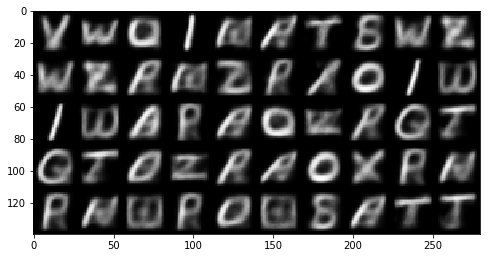

In [10]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model_2d.batch_size, model_2d.n_z])
x_generated = model_2d.generator(z)

n = np.sqrt(model_2d.batch_size).astype(np.int32)
I_generated = np.empty((h*5, w*10))
for i in range(5):
    for j in range(10):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')
plt.imsave('gen.jpg',I_generated, cmap='gray')

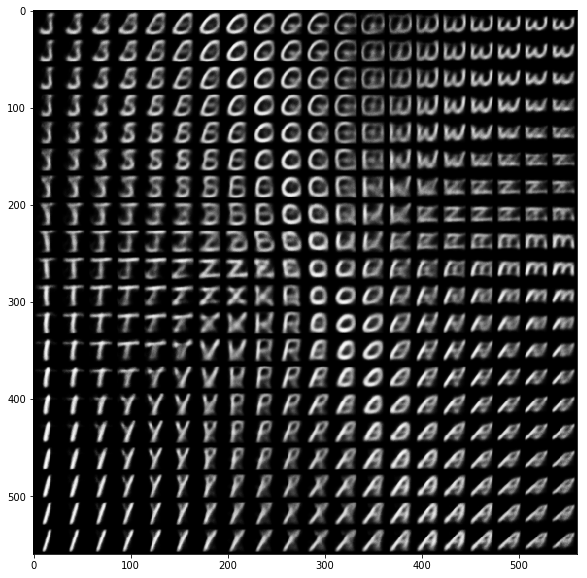

In [15]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(10, 10))        
plt.imshow(I_latent, cmap="gray")
plt.show()